In [ ]:
pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.8 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.14.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.14.0
    Uninstalling tensorflow-2.14.0:
      Successfully

In [ ]:
import os
import pandas as pd
import seaborn as sns
import os
import shutil
import tensorflow.keras as keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,TimeDistributed, Flatten, Bidirectional
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
import matplotlib.pyplot as plt
from keras.layers import BatchNormalization
from keras.regularizers import l2
import re

In [ ]:
train_dataset = pd.read_csv('Tweets.csv')

In [ ]:
train_dataset.head()

In [ ]:
train_dataset.tail()

,textID,text,selected_text,sentiment
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive
27480,6f7127d9d7,All this flirting going on - The ATG smiles...,All this flirting going on - The ATG smiles. Y...,neutral


In [ ]:
train_dataset.shape

(27481, 4)

In [ ]:
#checking if there are any null values
train_dataset.isnull().any()

textID           False
text              True
selected_text     True
sentiment        False
dtype: bool

In [ ]:
#checking out number of negative, neutral and positive sentiment labels in the dataset.
print("Number of positive sentiment in train data of length: {0} is {1}".format(len(train_dataset), len(train_dataset[train_dataset['sentiment']=="positive"])))
print("Number of negative sentiment in train data of length: {0} is {1}".format(len(train_dataset), len(train_dataset[train_dataset['sentiment']=="neutral"])))
print("Number of neutral sentiment in train data of length: {0} is {1}".format(len(train_dataset), len(train_dataset[train_dataset['sentiment']=="negative"])))

Number of positive sentiment in train data of length: 27481 is 8582
Number of negative sentiment in train data of length: 27481 is 11118
Number of neutral sentiment in train data of length: 27481 is 7781


<Axes: xlabel='sentiment'>

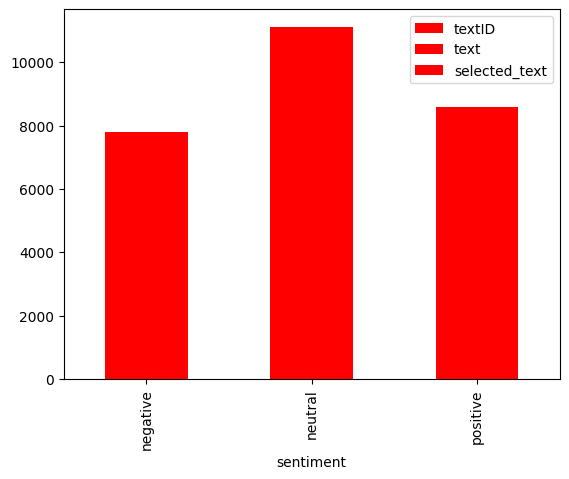

In [ ]:
#plotting the same.
train_dataset.groupby('sentiment').count().plot.bar(color='red')

<ipython-input-11-65b4696ea094>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_dataset.text.str.len())


<Axes: xlabel='text', ylabel='Density'>

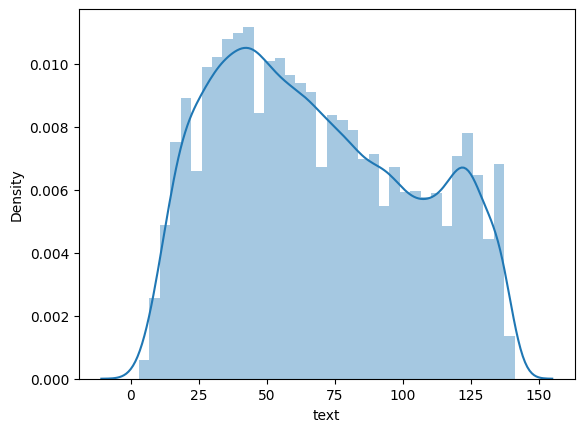

In [ ]:
#plotting the distibution of number of characters in the tweets
sns.distplot(train_dataset.text.str.len())

In [ ]:
#dropping unneccessary columns
train_dataset = train_dataset.drop(['textID','selected_text'],axis=1)
train_dataset.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [ ]:
#converting data in text column to string
train_dataset.text=train_dataset.text.astype(str)
#removing neutral categories
train_dataset_without_neutral = train_dataset[train_dataset.sentiment!="neutral"]
train_dataset_without_neutral.text=train_dataset_without_neutral.text.astype(str)
#converting train_dataset and train_dataset_without neutral to lower case
train_dataset.text = train_dataset.text.str.lower()
train_dataset_without_neutral.text = train_dataset_without_neutral.text.str.lower()
#cleaning more
train_dataset['text'] = train_dataset['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
train_dataset_without_neutral['text'] = train_dataset_without_neutral['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

<ipython-input-14-d5d7745b72d3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dataset_without_neutral.text=train_dataset_without_neutral.text.astype(str)
<ipython-input-14-d5d7745b72d3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dataset_without_neutral.text = train_dataset_without_neutral.text.str.lower()
<ipython-input-14-d5d7745b72d3>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


<Axes: xlabel='sentiment'>

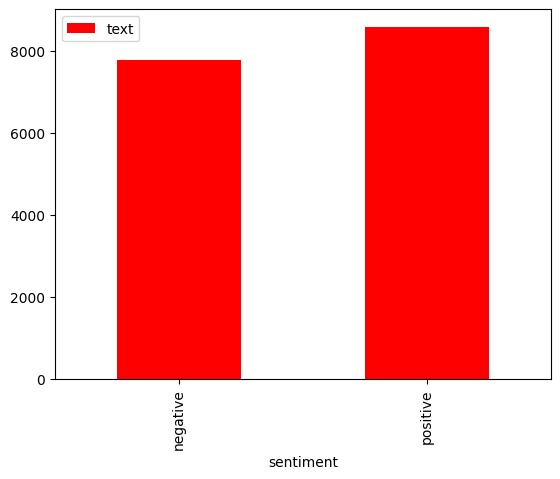

In [ ]:
train_dataset_without_neutral.groupby('sentiment').count().plot.bar(color='red')

In [ ]:
max_features = 5000
# removing unneccessary punctuations while tokenizing
tokenizer = Tokenizer(num_words= max_features, oov_token='OOV',filters='!"#$%&()*+,-./:;<=>@[\]^_`{|}~')
tokenizer.fit_on_texts(train_dataset['text'].values)
features = tokenizer.texts_to_sequences(train_dataset['text'].values)
features = pad_sequences(features,padding='post')

In [ ]:
max_features = 5000
# removing unneccessary punctuations while tokenizing
tokenizer2 = Tokenizer(num_words= max_features, oov_token='OOV',filters='!"#$%&()*+,-./:;<=>@[\]^_`{|}~')
tokenizer2.fit_on_texts(train_dataset_without_neutral['text'].values)
features2 = tokenizer2.texts_to_sequences(train_dataset_without_neutral['text'].values)
features2 = pad_sequences(features2,padding='post')

In [ ]:
#getting numerical data for labels
labels = pd.get_dummies(train_dataset['sentiment']).values
X_train, X_val, Y_train, Y_val = train_test_split(features,labels, test_size = 0.33, random_state = 42)
X_train, X_val, Y_train, Y_val = train_test_split(features,labels, test_size = 0.33, random_state = 42)

print("Input training features and label shape are {},{}".format(X_train.shape,Y_train.shape))
print("Input validation features and label shape are {}, {}".format(X_val.shape,Y_val.shape))

Input training features and label shape are (18412, 34),(18412, 3)
Input validation features and label shape are (9069, 34), (9069, 3)


In [ ]:
#getting numerical data for labels
labels1 = pd.get_dummies(train_dataset_without_neutral['sentiment']).values
X_train1, X_val1, Y_train1, Y_val1 = train_test_split(features2,labels1, test_size = 0.33, random_state = 42)

print("Input training features and label shape are {},{}".format(X_train1.shape,Y_train1.shape))
print("Input validation features and label shape are {}, {}".format(X_val1.shape,Y_val1.shape))

Input training features and label shape are (10963, 33),(10963, 2)
Input validation features and label shape are (5400, 33), (5400, 2)


In [ ]:
embedding_dimension = 128
LSTM_model = Sequential()
LSTM_model.add(Embedding(max_features, embedding_dimension, input_length = features.shape[1]))
LSTM_model.add(SpatialDropout1D(0.4))
LSTM_model.add(LSTM(128, kernel_regularizer=l2(0.1),  dropout=0.4,recurrent_dropout=0.4))
LSTM_model.add(Dense(3, activation='softmax'))
LSTM_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 34, 128)           640000    
                                                                 
 spatial_dropout1d (Spatial  (None, 34, 128)           0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 771971 (2.94 MB)
Trainable params: 771971 (2.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
embedding_dimension = 128
LSTM_model_binary = Sequential()
LSTM_model_binary.add(Embedding(max_features, embedding_dimension, input_length = features.shape[1]))
LSTM_model_binary.add(SpatialDropout1D(0.4))
LSTM_model_binary.add(LSTM(128, kernel_regularizer=l2(0.1),  dropout=0.4,recurrent_dropout=0.4))
LSTM_model_binary.add(Dense(2, activation='softmax'))
LSTM_model_binary.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
LSTM_model_binary.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 34, 128)           640000    
                                                                 
 spatial_dropout1d_1 (Spati  (None, 34, 128)           0         
 alDropout1D)                                                    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 771842 (2.94 MB)
Trainable params: 771842 (2.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
batch_size = 256
LSTM_model_history = LSTM_model.fit(X_train,Y_train, epochs = 50, batch_size=batch_size, verbose=1, shuffle=True,validation_data=(X_val,Y_val))

Epoch 1/50
72/72 [==============================] - 38s 484ms/step - loss: 8.6999 - accuracy: 0.4021 - val_loss: 2.2940 - val_accuracy: 0.4105
Epoch 2/50
72/72 [==============================] - 30s 421ms/step - loss: 1.3217 - accuracy: 0.4976 - val_loss: 0.8962 - val_accuracy: 0.5923
Epoch 3/50
72/72 [==============================] - 34s 468ms/step - loss: 0.8145 - accuracy: 0.6486 - val_loss: 0.8352 - val_accuracy: 0.6374
Epoch 4/50
72/72 [==============================] - 33s 455ms/step - loss: 0.7339 - accuracy: 0.6942 - val_loss: 0.7692 - val_accuracy: 0.6709
Epoch 5/50
72/72 [==============================] - 31s 436ms/step - loss: 0.7179 - accuracy: 0.7099 - val_loss: 0.7853 - val_accuracy: 0.6673
Epoch 6/50
72/72 [==============================] - 35s 485ms/step - loss: 0.6782 - accuracy: 0.7321 - val_loss: 0.7747 - val_accuracy: 0.6786
Epoch 7/50
72/72 [==============================] - 30s 419ms/step - loss: 0.6752 - accuracy: 0.7363 - val_loss: 0.7911 - val_accuracy: 0.6750

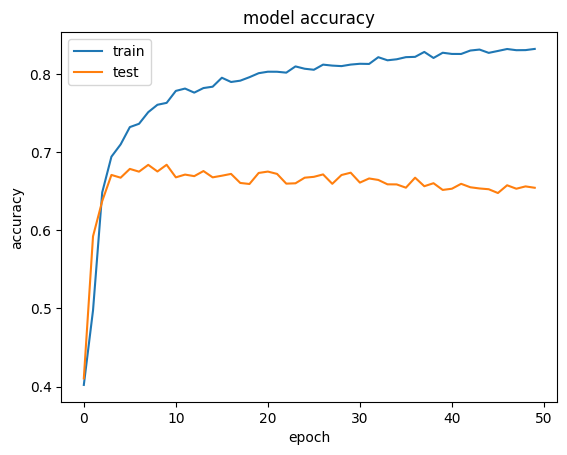

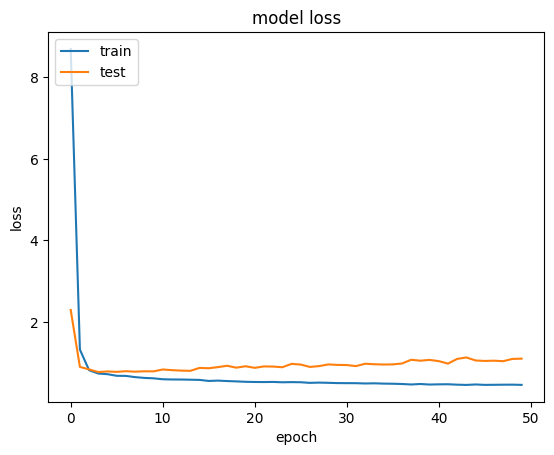

In [ ]:
plt.plot(LSTM_model_history.history['accuracy'])
plt.plot(LSTM_model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(LSTM_model_history.history['loss'])
plt.plot(LSTM_model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
train_accuracy = LSTM_model_history.history['accuracy'][-1]
test_accuracy = LSTM_model_history.history['val_accuracy'][-1]

# Print the accuracy values
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.8321
Test Accuracy: 0.6544


In [ ]:
vocab_size = len(tokenizer.word_index)+1 # 1 for that extra OOV

In [ ]:
# main model
BiLSTM = Sequential()
BiLSTM.add(Embedding(vocab_size,100,input_length = features2.shape[1]))
BiLSTM.add(Bidirectional (LSTM (100,return_sequences=True,dropout=0.2,recurrent_dropout=0.2, kernel_regularizer=l2(0.1)),merge_mode='concat'))
BiLSTM.add(TimeDistributed(Dense(100,activation='relu')))
BiLSTM.add(SpatialDropout1D(0.4))
BiLSTM.add(Flatten())
BiLSTM.add(Dense(2,activation='softmax'))
BiLSTM.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

In [ ]:
batch_size = 256
BiLSTM_model_history = BiLSTM.fit(X_train1,Y_train1, epochs = 50, batch_size=batch_size, verbose=1, validation_data=(X_val1,Y_val1))

Epoch 1/50
43/43 [==============================] - 38s 733ms/step - loss: 18.9874 - accuracy: 0.6027 - val_loss: 8.7769 - val_accuracy: 0.7552
Epoch 2/50
43/43 [==============================] - 32s 742ms/step - loss: 4.6482 - accuracy: 0.8447 - val_loss: 2.0103 - val_accuracy: 0.8448
Epoch 3/50
43/43 [==============================] - 30s 694ms/step - loss: 1.0367 - accuracy: 0.9030 - val_loss: 0.6230 - val_accuracy: 0.8491
Epoch 4/50
43/43 [==============================] - 34s 804ms/step - loss: 0.3393 - accuracy: 0.9194 - val_loss: 0.4182 - val_accuracy: 0.8476
Epoch 5/50
43/43 [==============================] - 30s 692ms/step - loss: 0.2033 - accuracy: 0.9372 - val_loss: 0.4623 - val_accuracy: 0.8433
Epoch 6/50
43/43 [==============================] - 32s 749ms/step - loss: 0.1909 - accuracy: 0.9354 - val_loss: 0.4428 - val_accuracy: 0.8441
Epoch 7/50
43/43 [==============================] - 30s 699ms/step - loss: 0.1636 - accuracy: 0.9504 - val_loss: 0.4729 - val_accuracy: 0.842

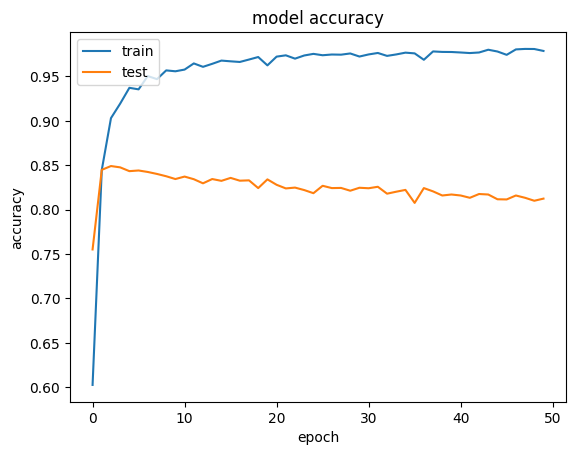

In [ ]:
plt.plot(BiLSTM_model_history.history['accuracy'])
plt.plot(BiLSTM_model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

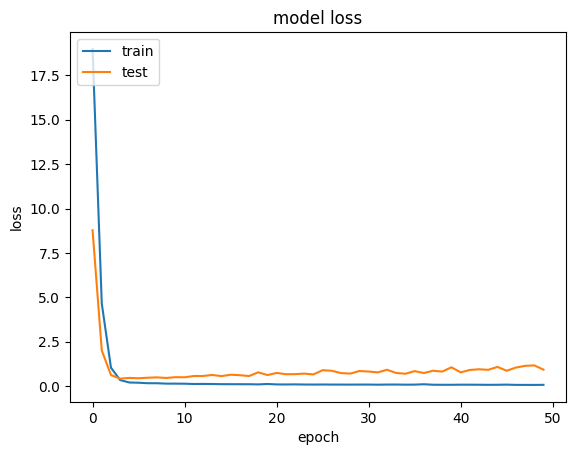

In [ ]:
# summarize history for loss
plt.plot(BiLSTM_model_history.history['loss'])
plt.plot(BiLSTM_model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Get the final training and test accuracy values
train_accuracy = BiLSTM_model_history.history['accuracy'][-1]
test_accuracy = BiLSTM_model_history.history['val_accuracy'][-1]

# Print the accuracy values
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Training Accuracy: 0.9787
Test Accuracy: 0.8124


In [ ]:
import numpy as np
import pandas as pd
from tabulate import tabulate

# ... (your existing code)

# Creating a DataFrame for better visualization
predictions_df = pd.DataFrame({
    'Text': [tokenizer.sequences_to_texts([sequence])[0] for sequence in X_val],
    'True Sentiment': true_labels,
    'Predicted Sentiment': predicted_labels
})

# Display the DataFrame using tabulate
print(tabulate(predictions_df.head(10), headers='keys', tablefmt='pretty', showindex=False))

# Visualizing a few randomly selected tweets and their predictions
for _ in range(10):
    index = np.random.randint(0, len(X_val))
    tweet = predictions_df.iloc[index]['Text']
    true_sentiment = predictions_df.iloc[index]['True Sentiment']
    predicted_sentiment = predictions_df.iloc[index]['Predicted Sentiment']

    print(f"Tweet: {tweet}")
    print(f"True Sentiment: {true_sentiment}")
    print(f"Predicted Sentiment: {predicted_sentiment}")
    print("\n")


+------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+---------------------+
|                                                                            Text                                                                            | True Sentiment | Predicted Sentiment |
+------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+---------------------+
|         OOV are you coming to OOV at any point OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV         |    positive    |      negative       |
|       resting had a whole day of walking OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV       |    negative    |      negative       |
|         

In [ ]:
# Predictions on validation data for BiLSTM model
predictions_BiLSTM = BiLSTM.predict(X_val1)

# Ensure the predictions have the correct shape
if predictions_BiLSTM.shape[1] > 1:
    # For multiclass classification, use argmax
    predicted_labels_BiLSTM = [list(train_dataset_without_neutral['sentiment'].unique())[np.argmax(prediction)] for prediction in predictions_BiLSTM]
else:
    # For binary classification, round the probabilities
    predicted_labels_BiLSTM = ['positive' if prediction > 0.5 else 'negative' for prediction in predictions_BiLSTM]

# Map true labels to sentiment categories
true_labels_BiLSTM = [list(train_dataset_without_neutral['sentiment'].unique())[np.argmax(label)] for label in Y_val1]

# Creating a DataFrame for better visualization for BiLSTM model
predictions_df_BiLSTM = pd.DataFrame({
    'Text': [tokenizer2.sequences_to_texts([sequence])[0] for sequence in X_val1],
    'True Sentiment': true_labels_BiLSTM,
    'Predicted Sentiment': predicted_labels_BiLSTM
})

# Display the DataFrame for BiLSTM model using tabulate
print(tabulate(predictions_df_BiLSTM.head(10), headers='keys', tablefmt='pretty', showindex=False))

# Visualizing a few randomly selected tweets and their predictions for BiLSTM model
for _ in range(20):
    index = np.random.randint(0, len(X_val1))
    tweet = predictions_df_BiLSTM.iloc[index]['Text']
    true_sentiment = predictions_df_BiLSTM.iloc[index]['True Sentiment']
    predicted_sentiment = predictions_df_BiLSTM.iloc[index]['Predicted Sentiment']

    print(f"Tweet: {tweet}")
    print(f"True Sentiment: {true_sentiment}")
    print(f"Predicted Sentiment: {predicted_sentiment}")
    print("\n")


169/169 [==============================] - 4s 22ms/step
+---------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+---------------------+
|                                                                          Text                                                                           | True Sentiment | Predicted Sentiment |
+---------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+---------------------+
|         thanks will try to OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV          |    positive    |      positive       |
|   today is lame because i am not in orlando i am soooo looking forward to next friday OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV   |    negat